# Black-Litterman Framework
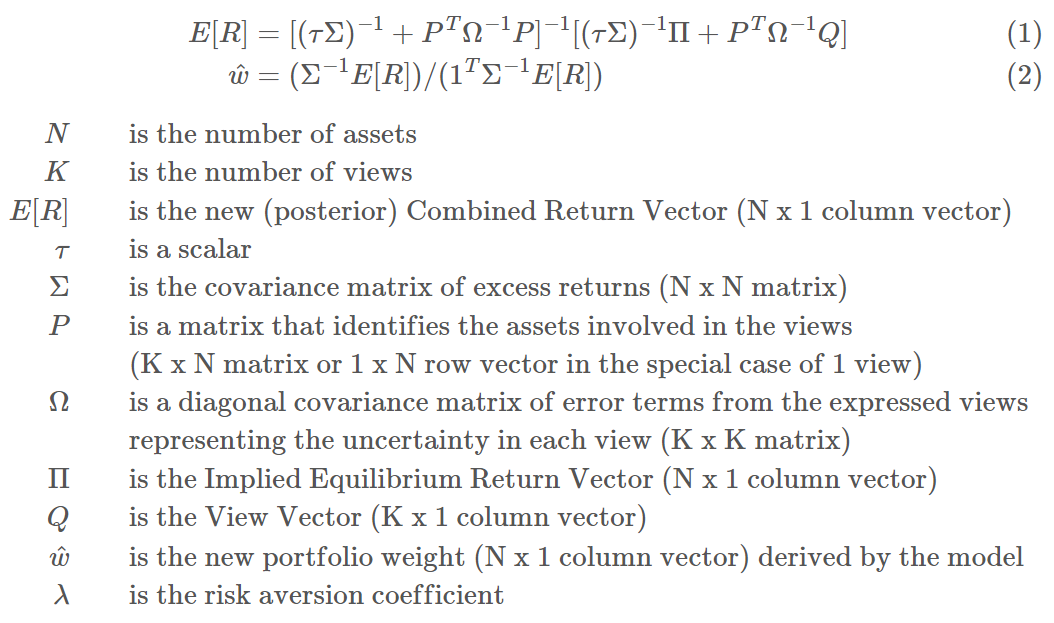

Black-Litterman Framework를 간단히 요약하자면,

수식(1)은 시장에서 도출된 '시장 균형 수익률($\pi$)'과 '투자자의 View($Q$)' 조합하여 새로운 기대수익률($E[R]$)을 만드는 식이다.

이렇게 도출된 기대수익률과 수식(2)(unconstrained mean-variance maximization)을 이용하여 기존 Markowitz의 Mean-Variance Optimization의 한계를 해결한 새로운 포트폴리오 비중($\hat{w}$)을 구하는 것이 모델의 최종 목표이다.

##

##

# 1. Calculate Implied Excess Equilibrium Return Vector($\Pi$)

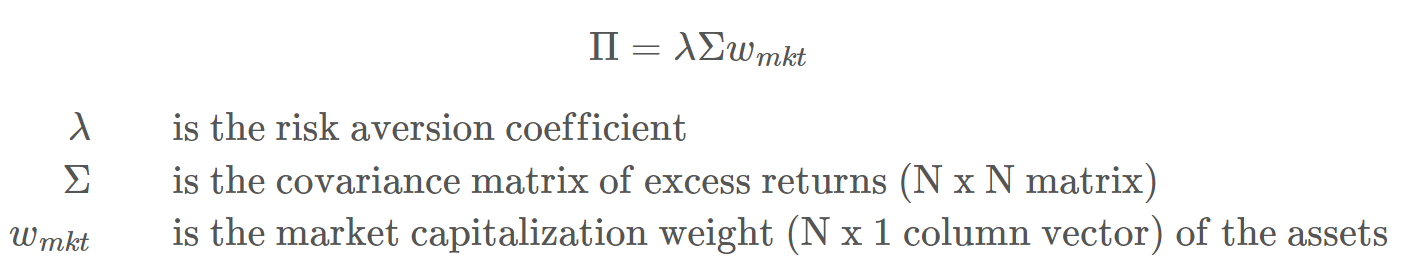

##

## 1.1 사용할 데이터 전처리

In [1]:
import numpy as np
import pandas as pd
from numpy.linalg import inv # 역행렬 계산을 위함

In [2]:
# Asset class별 수익률 불러오기(1972~2020)
asset_returns_orig = pd.read_csv('asset_returns.csv', index_col='Year', parse_dates=True)

In [5]:
asset_returns_orig.head()

,Inflation,US Stock Market,US Large Cap,US Large Cap Value,US Large Cap Growth,US Mid Cap,US Mid Cap Value,US Mid Cap Growth,US Small Cap,US Small Cap Value,...,Corporate Bonds,Long-Term Corporate Bonds,High Yield Corporate Bonds,Short-Term Tax-Exempt,Intermediate-Term Tax-Exempt,Long-Term Tax-Exempt,REIT,Gold,Precious Metals,Commodities
Year,,,,,,,,,,,,,,,,,,,,,
1972-01-01,0.03,0.18,0.19,0.15,0.23,0.08,0.12,0.04,0.09,0.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.49,NaN,NaN
1973-01-01,0.09,-0.18,-0.16,-0.10,-0.23,-0.24,-0.14,-0.33,-0.33,-0.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.73,NaN,NaN
1974-01-01,0.12,-0.28,-0.27,-0.21,-0.32,-0.26,-0.20,-0.33,-0.28,-0.21,...,NaN,-0.02,NaN,NaN,NaN,NaN,NaN,0.66,NaN,NaN
1975-01-01,0.07,0.38,0.37,0.41,0.33,0.49,0.57,0.42,0.55,0.54,...,NaN,0.10,NaN,NaN,NaN,NaN,NaN,-0.25,NaN,NaN
1976-01-01,0.05,0.26,0.24,0.33,0.15,0.37,0.47,0.27,0.45,0.55,...,NaN,0.15,NaN,NaN,NaN,NaN,NaN,-0.04,NaN,NaN


In [3]:
# Asset class별 시가총액 기준 weight 불러오기
asset_weights = pd.read_csv('asset_weights.csv', index_col='asset_class')

In [7]:
asset_weights

,weight
asset_class,
US Large Cap Value,0.162
US Large Cap Growth,0.163
US Small Cap Value,0.022
US Small Cap Growth,0.022
Emerging Markets,0.030
Intl Developed ex-US Market,0.299
Total US Bond Market,0.077
Global Bonds (Unhedged),0.224


In [12]:
# 만들고자 하는 global portfolio의 칼럼 선택
cols = ['Global Bonds (Unhedged)','Total US Bond Market','US Large Cap Growth',
            'US Large Cap Value','US Small Cap Growth','US Small Cap Value','Emerging Markets',
            'Intl Developed ex-US Market','Short Term Treasury']

In [13]:
# NA값 제외
asset_returns = asset_returns_orig[cols].dropna()

In [14]:
# Short Term Treasury rate 불러오기
treasury_rate = asset_returns['Short Term Treasury']

In [16]:
# asset_returns 데이터프레임 내 데이터 타입 한 번에 float으로 바꾸고 NA값 제외 (astype() 참고 사이트: https://seong6496.tistory.com/134)
asset_returns = asset_returns[cols[:-1]].astype(float).dropna()

In [17]:
asset_weights = asset_weights.loc[cols[:-1]]

In [21]:
# return 평균값 구하기
asset_returns.mean()

Global Bonds (Unhedged)        0.059615
Total US Bond Market           0.054231
US Large Cap Growth            0.131538
US Large Cap Value             0.102308
US Small Cap Growth            0.119615
US Small Cap Value             0.114615
Emerging Markets               0.100000
Intl Developed ex-US Market    0.063462
dtype: float64

In [22]:
# Asset들의 가중치
asset_weights

,weight
asset_class,
Global Bonds (Unhedged),0.224
Total US Bond Market,0.077
US Large Cap Growth,0.163
US Large Cap Value,0.162
US Small Cap Growth,0.022
US Small Cap Value,0.022
Emerging Markets,0.030
Intl Developed ex-US Market,0.299


##

## 1.2 Risk Aversion Coefficient($\lambda$)을 계산하기 위해 global market portfolio의 mean return과 variance 계산

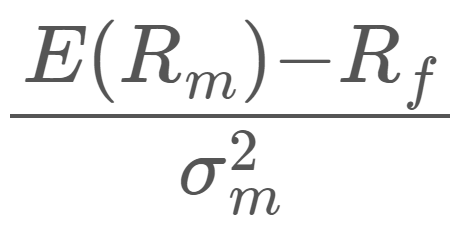

$\lambda$ = (시가총액가중 포트폴리오의 평균 초과수익률 / 분산)이라 가정

In [23]:
# subtract 함수를 이용해 return - t_rate -> excess return을 구함
excess_asset_returns = asset_returns.subtract(treasury_rate, axis=0)

In [24]:
# excess return의 공분산을 구함
cov = excess_asset_returns.cov()

In [25]:
# excess return의 평균을 weight와 곱해준 뒤, 더해줌
global_return = excess_asset_returns.mean().multiply(asset_weights['weight'].values).sum()

In [27]:
# Asset의 가중치 행렬과, {공분산 행렬과 가중치 행렬을 곱한 것}을 행렬곱해줌.
market_var = np.matmul(asset_weights.values.reshape(len(asset_weights)).T,
                       np.matmul(cov.values, asset_weights.values.reshape(len(asset_weights))))
# np.matual(): 행렬곱(참고: https://numpy.org/doc/stable/reference/generated/numpy.matmul.html)
# reshape(): 데이터의 구조를 재배열(차원 변경)(참고: https://yganalyst.github.io/data_handling/memo_5/)
# .T: .T는 구조의 전치(Transposed)를 말한다. 여기에서는 전치행렬.

In [33]:
print(f'The global market mean return is {global_return:.4f} and the variance is {market_var:.6}')
# f는 f-tring formatting임. 문자열 중 중괄호{} 안에 있는 값을 반환해서 출력함.
# global_return, market_var 뒤에 붙어 있는 (.n)는 소수점 n 번째 자리까지 출력할 것이라는 걸 나타냄. 

The global market mean return is 0.0446 and the variance is 0.0202548


In [34]:
risk_aversion = global_return / market_var

In [35]:
print(f'The risk aversion parameter is {risk_aversion:.2f}')

The risk aversion parameter is 2.20


이렇게 구한 $\lambda$는 Implied Equilibrium Return Vector를 계산할 때 사용된다.

##

## 1.3 포트폴리오의 가중치를 reverse engineer(역설계)하여 Implied Equilibrium Return Vector 계산

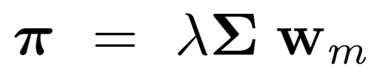

즉 Prior Return

In [36]:
def implied_rets(risk_aversion, sigma, w):
    implied_rets = risk_aversion * sigma.dot(w).squeeze() # squeeze() 함수는 차원이 1인 차원을 모두 제거.
    return implied_rets

implied_equilibrium_returns = implied_rets(risk_aversion, cov, asset_weights)

implied_equilibrium_returns

Global Bonds (Unhedged)        0.012871
Total US Bond Market           0.002439
US Large Cap Growth            0.060436
US Large Cap Value             0.051548
US Small Cap Growth            0.056798
US Small Cap Value             0.043902
Emerging Markets               0.076184
Intl Developed ex-US Market    0.063076
Name: weight, dtype: float64

##

##

# 2. Set Investor’s Subjective Views

1번에서 시장의 균형 수익률을 구했다(사실 이는 주어지는 것).

Black-Litterman Framework에서 사용되는 기대 수익률은, 균형 수익률에 투자자의 주관적 관점을 가미하여 창출된 새로운 기대수익률이다.

따라서 투자자의 관점을 다음과 같이 가정해보자.

* View 1: ‘Emerging Markets’은 9.25%의 절대 초과 수익률을 보일 것이다.

* View 2: 'US Large Cap Growth'와 'US Small Cap Growth'는 'US Large Cap Value'와 'US Small Cap Value'를 0.5%만큼 outperform할 것이다(균형 수익률 기반에서 1% ~ 1.2%인 것과는 다르게).

* View 3: 'Intl Developed ex-US Market'은 5.5%의 절대 초과 수익률을 보일 것이다(균형 수익률 기반에서 6.31%인 것과는 다르게).

여기에서 View 1, 3은 Absolute view이고, View 2는 Relative view이다.

(상대적 관점을 쉽게 말하자면, 현재 시장에서 지배적인 asset class에 대한 수익률 컨센서스와 비교해 투자자가 초과 손익이 날 것이라고 생각하고 있는 것이다)

여기에서 투자자의 View(K)는 3개이기 때문에, View Vector(Q)는 3 x 1 Column Vector이다.

투자자 관점의 불확실성으로 인해, 평균이 0이고 공분산이 omega인 random, unknown, independent, normally-distribured한 오차항 벡터 epsilon이 생성된다. 

##

## 2.1 Q(View Vector) 구하기

In [37]:
Q = np.array([0.0925, 0.005, 0.055])

##

## 2.2 P(Picking Matrix) 구하기

3개의 View와 8개의 자산이 있으므로 3 x 8 행렬을 만들 수 있다.

* Absolute view의 경우에는 하나의 column이 1이 되는 row 형태로 나타내고,

* Relative View의 경우에는 상대적으로 outperform할 자산의 위치에 해당하는 column이 양의 값을,비교 대상이 되는 자산의 위치에 해당하는 column에는 음의 값을 부여하며, 하나의 row의 모든 원소의 합은 0이 되게 맞춘다.


In [38]:
P = [[0, 0, 0, 0, 0, 0, 1, 0],  # 데이터 순서 상 7번째에 위치한 Emerging Markets에 1 부여
    [0, 0, .5, -.5, .5, -.5, 0, 0],  # 합이 0이 되게 맞춤
    [0, 0, 0, 0, 0, 0, 0, 1]]

그러나 위의 접근법은 '균등 가중법(equal weighting)'을 사용한 것이고,

이보다 더 현실적으로 시가총액에 따라 Asset class에 가중치를 부여하는 방법이 존재한다.

위 데이터의 경우에는 Large Cap 자산이 Small Cap 자산보다 약 7~8배 가량 규모가 크기 때문에, 이를 반영하여 P를 수정해줄 수 있다. 

In [40]:
P = np.asarray([[0, 0, 0, 0, 0, 0, 1, 0],
                [0, 0, .88, -.88, .12, -.12, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 1]])

위에서 정의된 행렬 P의 $k$번째 행(1 x N row vector)을 $p_k$로 표기한다.

이를 이용해, 각 view를 기반으로 구성된 portfolio의 variance를 $p_k * \Sigma p^T_k$로 구할 수 있다.

In [41]:
view1_var = np.matmul(P[0].reshape(len(P[0])),np.matmul(cov.values, P[0].reshape(len(P[0])).T))
view2_var = np.matmul(P[1].reshape(len(P[1])),np.matmul(cov.values, P[1].reshape(len(P[1])).T))
view3_var = np.matmul(P[2].reshape(len(P[2])),np.matmul(cov.values, P[2].reshape(len(P[2])).T))

print(f'The Variance of View 1 Portfolio is {view1_var}, and the standard deviation is {np.sqrt(view1_var):.3f}\n',\
      f'The Variance of View 2 Portfolio is {view2_var}, and the standard deviation is {np.sqrt(view2_var):.3f}\n',\
      f'The Variance of View 3 Portfolio is {view3_var}, and the standard deviation is {np.sqrt(view3_var):.3f}')

The Variance of View 1 Portfolio is 0.09655215384615386, and the standard deviation is 0.311
 The Variance of View 2 Portfolio is 0.014627059446153863, and the standard deviation is 0.121
 The Variance of View 3 Portfolio is 0.04505784615384616, and the standard deviation is 0.212


##

## 2.3 $\tau$: Scalar 'Tuning' Constant

Prior estimate of returns($\pi$)에 대한 불확실 정도를 나타내는 수치다. $\tau$ 값이 작을 수록, Black-Litterman Framework에 의해 계산되는 Combined return vector($E[R]$)가 Implied equilibrium return($\pi$)에 가까워지게 된다.

그러나 아쉽게도 이를 추정하는 명확한 방법은 정해지지 않았다. $\tau$값을 설정하는 아래와 같은 방법들이 제시되었다.

1. 0.01과 0.05 사이의 값으로 최초 설정한 뒤, tracking error를 줄이는 방향으로 조정
2. 1로 설정(Satchell and Scowcroft, 2000)
3. 1 / (number of observation)로 설정(Blamont and Firoozye, 2003)

딱 잘라 말할 수 있는 기준이 없으므로, 이후 $\omega$ 값을 도출할 때 $\tau$를 factor-out 시킬 수 있도록 값을 설정하는 방법이 있다(Idzorek, 2007). 따라서 $\tau$에 0이 아닌 어떠한 값을 넣어도, 최종 결과($E[R]$)에는 영향을 미치지 않는다.

여기에서는 $\tau = 1$로 설정하겠다.

In [42]:
tau = 1

##

## 2.4 $\Omega$: Uncertainty Matrix of Views

개별 view의 불확실한 정도를 나타내는 대각행렬이다. 행렬의 원소인 $w_k$가 0에 가까울 수록, view k의 신뢰도가 100% 가깝다는 것을 의미하고, $w_k$가 클 수록 해당 view의 불확실성이 높음을 의미한다.

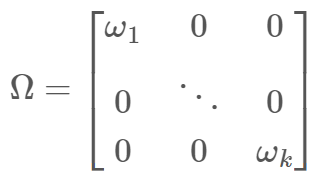


만약 개별 view에 대한 신뢰도 정보를 가지고 있다면, $\Omega$의 값을 직접 입력할 수 있다. 그러나 여기에서는 개별 view를 기반으로 생성된 portfolio의 variance를 이용할 것이다.

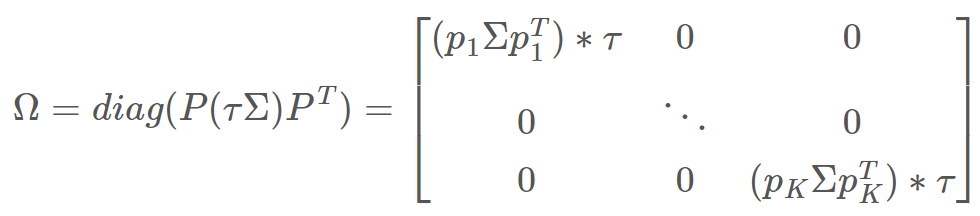

이렇게 $\Omega$를 설정하면 $\tau$값이 변해도 $E[R]$값이 변하지 않는다.

따라서 투자자는 view를 설정할 때 이용되는 input에 집중하면 된다.

In [44]:
def error_cov_matrix(sigma, tau, P):
    matrix = np.diag(np.diag(P.dot(tau * cov).dot(P.T)))
    return matrix

omega = error_cov_matrix(cov, tau, P)
omega

array([[0.09655215, 0.        , 0.        ],
       [0.        , 0.01462706, 0.        ],
       [0.        , 0.        , 0.04505785]])

##

##

# 3. Calculate Combined return vector($E[R]$) & $\hat{w}$

## 3.1 view based return vector

In [48]:
sigma_scaled = cov * tau
BL_return_vector = implied_equilibrium_returns + sigma_scaled.dot(P.T).dot(inv(P.dot(sigma_scaled).dot(P.T) + omega).dot(Q - P.dot(implied_equilibrium_returns)))

BL_return_vector

Global Bonds (Unhedged)        0.013164
Total US Bond Market           0.002431
US Large Cap Growth            0.057558
US Large Cap Value             0.050862
US Small Cap Growth            0.056650
US Small Cap Value             0.044873
Emerging Markets               0.079139
Intl Developed ex-US Market    0.062425
dtype: float64

##

## 3.2 새로 도출한 $E[R]$과 Implied equilibrium returns 비교

In [51]:
returns_table = pd.concat([implied_equilibrium_returns, BL_return_vector], axis=1) * 100
returns_table.columns = ['Implied Returns', 'BL Return Vector']
returns_table['Difference'] = returns_table['BL Return Vector'] - returns_table['Implied Returns']
returns_table.style.format('{:,.2f}%')

,Implied Returns,BL Return Vector,Difference
Global Bonds (Unhedged),1.29%,1.32%,0.03%
Total US Bond Market,0.24%,0.24%,-0.00%
US Large Cap Growth,6.04%,5.76%,-0.29%
US Large Cap Value,5.15%,5.09%,-0.07%
US Small Cap Growth,5.68%,5.67%,-0.01%
US Small Cap Value,4.39%,4.49%,0.10%
Emerging Markets,7.62%,7.91%,0.30%
Intl Developed ex-US Market,6.31%,6.24%,-0.07%


##

## 3.3 기존 가중치 asset_weights와 새로 도출한 가중치 $\hat{w}$ 비교

In [62]:
inverse_cov = pd.DataFrame(inv(cov.values), index=cov.columns, columns=cov.index)
BL_weights_vector = inverse_cov.dot(BL_return_vector)
BL_weights_vector = BL_weights_vector/sum(BL_weights_vector)

MV_weights_vector = inverse_cov.dot(excess_asset_returns.mean())
MV_weights_vector = MV_weights_vector/sum(MV_weights_vector)
weights_table = pd.concat([BL_weights_vector, asset_weights, MV_weights_vector], axis=1) * 100
weights_table.columns = ['BL Weights', 'Market Cap Weights', 'Mean-Var Weights']
weights_table['BL/Mkt Cap Diff'] = weights_table['BL Weights'] - weights_table['Market Cap Weights']
weights_table.style.format('{:,.2f}%')

,BL Weights,Market Cap Weights,Mean-Var Weights,BL/Mkt Cap Diff
Global Bonds (Unhedged),22.69%,22.40%,-13.99%,0.29%
Total US Bond Market,7.80%,7.70%,107.26%,0.10%
US Large Cap Growth,10.14%,16.30%,17.54%,-6.16%
US Large Cap Value,22.79%,16.20%,-19.05%,6.59%
US Small Cap Growth,1.36%,2.20%,-1.82%,-0.84%
US Small Cap Value,3.10%,2.20%,16.43%,0.90%
Emerging Markets,9.40%,3.00%,6.39%,6.40%
Intl Developed ex-US Market,22.72%,29.90%,-12.75%,-7.18%


##

## 3.4 기존 Market Cap weights와 Black-Litterman weights간 변화 양상

1. 위의 가중치 비교에서 'US Large Cap Growth'(-6.16%)와 'US Small Cap Growth'(-0.84%) class는 가중치가 하락했고, 'US Large Cap Value"(+6.59%)와 'US Small Cap Value'(+0.90%) class는 가중치가 상승했음을 볼 수 있다.

2. 'Emerging Markets'(+6.40%) class의 가중치가 상승했다.

3. 'Intl Developed ex-US Market'(-7.18%) class의 가중치가 하락했다.

4. 나머지 두 Asset class인 'Global Bonds (Unhedged)'와 'Total US Bond Market' class에 대한 가중치는 실질적으로 변동이 거의 없다.

##

## 3.5 Asset class 가중치 시각화

1) Black-Litterman 모델 (3가지 View를 통합)

2) 시가총액 가중치

3) Mean-Variance model (평균-분산 모형, historic mean을 input으로 사용).

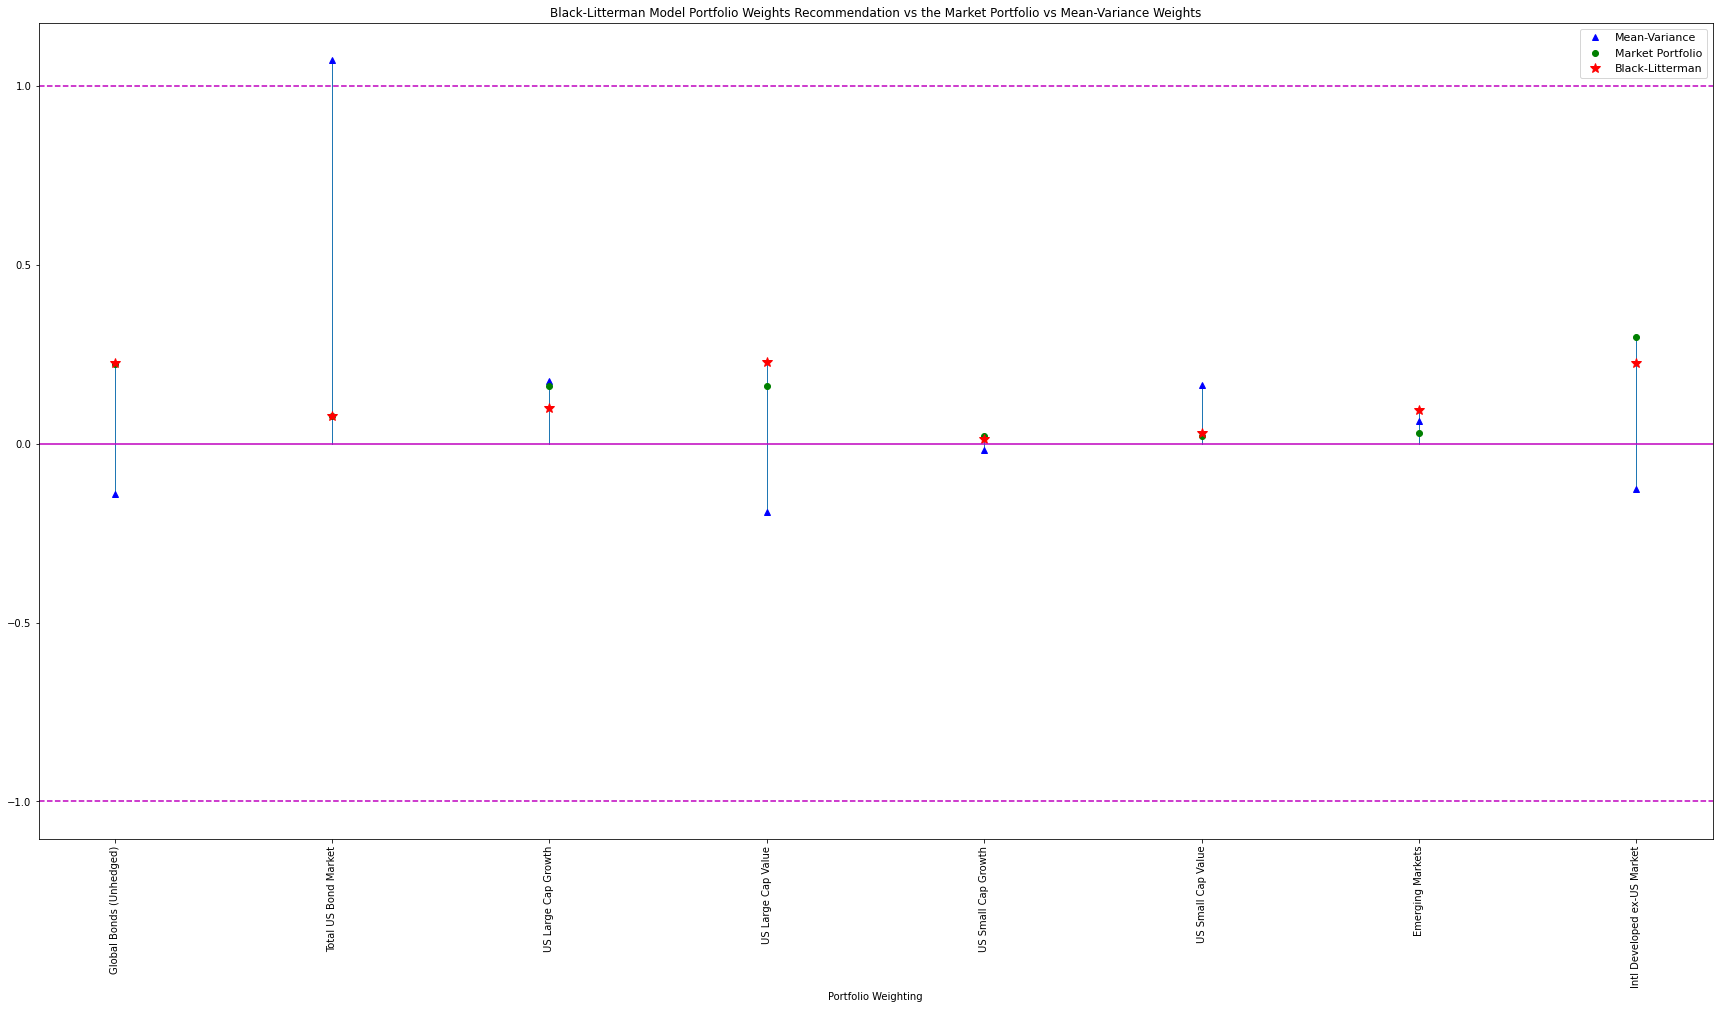

In [71]:
import matplotlib.pyplot as plt
N = BL_weights_vector.shape[0]
fig, ax = plt.subplots(figsize=(30, 15))
ax.set_title('Black-Litterman Model Portfolio Weights Recommendation vs the Market Portfolio vs Mean-Variance Weights')
ax.plot(np.arange(N)+1, MV_weights_vector, '^', c='b', label='Mean-Variance')
ax.plot(np.arange(N)+1, asset_weights, 'o', c='g', label='Market Portfolio')
ax.plot(np.arange(N)+1, BL_weights_vector, '*', c='r',markersize=10, label='Black-Litterman')
ax.vlines(np.arange(N)+1, 0, BL_weights_vector, lw=1)
ax.vlines(np.arange(N)+1, 0, MV_weights_vector, lw=1)
ax.vlines(np.arange(N)+1, 0, asset_weights, lw=1)
ax.axhline(0, c='m')
ax.axhline(-1, c='m', ls='--')
ax.axhline(1, c='m', ls='--')
ax.set_xlabel('Assets')
ax.set_xlabel('Portfolio Weighting')
ax.xaxis.set_ticks(np.arange(1, N+1, 1))
ax.set_xticklabels(asset_weights.index.values)
plt.xticks(rotation=90, )
plt.legend(numpoints=1, fontsize=11)
plt.show()

##

# References

1. https://pythonforfinance.net/2020/11/27/black-litterman-portfolio-allocation-model-in-python/#more-17887

2. https://hwangheek.github.io/2021/black-litterman/

##

##